In [1]:
import numpy as np
import torch
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)
import pandas as pd
import matplotlib.pyplot as plt

In [212]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

NVIDIA GeForce RTX 2080 Ti
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
Number of devices: 1


# Model Components

In [213]:
class MaskedTransformerBlock(torch.nn.Module):
    def __init__(self,
                 latent_size = 64,
                 num_heads = 4,
                 dropout = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm1 = torch.nn.LayerNorm(latent_size)
        self.layer_norm2 = torch.nn.LayerNorm(latent_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()
        self.linear = torch.nn.Linear(latent_size,
                                      latent_size)
        self.mha = torch.nn.MultiheadAttention(latent_size,
                                               num_heads,
                                               dropout=dropout,
                                               batch_first=True)
    def make_causal_mask(self, sz: int):
        return torch.triu(torch.full((sz, sz), True), diagonal=1).to(device)
        # return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

    def forward(self, x):
        y = x
        y = self.layer_norm1(y)
        y = self.mha(y,y,y,attn_mask=self.make_causal_mask(y.shape[1]))[0]
        x = y = x + y
        y = self.layer_norm2(y)
        y = self.linear(y)
        y = self.activation(y)
        return x + y

In [214]:
class SinePositionEmbedding(torch.nn.Module):
    def __init__(self,
                 max_wavelength=10000.0,
                 **kwargs):
        super().__init__(**kwargs)
        self.max_wavelength = torch.Tensor([max_wavelength])

    def forward(self, x):
        input_shape = x.shape
        input_type = x.dtype
        seq_length = x.shape[-2]
        hidden_size = x.shape[-1]
        position = torch.arange(seq_length).to(input_type)
        min_freq = (1 / self.max_wavelength).to(input_type)
        timescales = torch.pow(
            min_freq,
            (2 * (torch.arange(hidden_size) // 2)).to(input_type)
            / torch.Tensor([hidden_size]).to(input_type)
        )
        angles = torch.unsqueeze(position, 1) * torch.unsqueeze(timescales, 0)
        cos_mask = (torch.arange(hidden_size) % 2).to(input_type)
        sin_mask = 1 - cos_mask
        positional_encodings = (
            torch.sin(angles) * sin_mask + torch.cos(angles) * cos_mask
        )
        return torch.broadcast_to(positional_encodings, input_shape).to(device)

In [215]:
temp = SinePositionEmbedding()
temp(torch.ones(size=(5,3,11)))[0,:,:]

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  1.8629e-01,  9.8250e-01,  3.5105e-02,
          9.9938e-01,  6.5793e-03,  9.9998e-01,  1.2328e-03,  1.0000e+00,
          2.3101e-04],
        [ 9.0930e-01, -4.1615e-01,  3.6605e-01,  9.3059e-01,  7.0166e-02,
          9.9754e-01,  1.3158e-02,  9.9991e-01,  2.4657e-03,  1.0000e+00,
          4.6203e-04]], device='cuda:0')

In [216]:
class MaskedSinePositionEmbedding(SinePositionEmbedding):
    def __init__(self,
                 **kwargs):
        super().__init__(**kwargs)

    def forward(self,x):
        return super().forward(x) * torch.sign(x)

In [219]:
temp = MaskedSinePositionEmbedding()
temp(torch.concat([torch.ones(size=(5,2,11)),torch.zeros(size=(5,1,11))],1).to(device))[0,:,:]

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [8.4147e-01, 5.4030e-01, 1.8629e-01, 9.8250e-01, 3.5105e-02, 9.9938e-01,
         6.5793e-03, 9.9998e-01, 1.2328e-03, 1.0000e+00, 2.3101e-04],
        [0.0000e+00, -0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       device='cuda:0')

In [281]:
def norm_dist_loss(y_pred, y_true):
    y_true = torch.unsqueeze(y_true,axis=-1)
    # Note that y_true is the original
    # regression target and y_pred will
    # be 2 values: mu and sigma (linear, softplus)
    l_mu, l_sigma = torch.unbind(y_pred, axis=-1)
    l_mu = torch.unsqueeze(l_mu,-1)
    l_sigma = torch.unsqueeze(l_sigma,-1)
        
    t1 = torch.log(l_sigma)
    t2 = torch.log(torch.Tensor([2.0]))/2.0
    t3 = torch.log(torch.Tensor([torch.pi]))/2.0
    t4 = torch.pow(l_mu-y_true,2.0) / (2.0 * torch.pow(l_sigma,2.0))

    loss_ = t1.to(device)+t2.to(device)+t3.to(device)+t4
    mask = torch.logical_not(torch.eq(y_true, 0)).to(loss_.dtype)
    loss_ *= mask
    
    return torch.squeeze(loss_)

In [405]:
y_pred = torch.concat([torch.ones(size=(2,10,1))*0.1,torch.ones(size=(2,10,1))*0.5],-1)
y_pred

tensor([[[0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000]],

        [[0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000],
         [0.1000, 0.5000]]])

In [406]:
y_true = torch.ones(size=(2,10,))
y_true

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [407]:
norm_dist_loss(y_pred.to(device),y_true.to(device)).cpu()

tensor([[1.8458, 1.8458, 1.8458, 1.8458, 1.8458, 1.8458, 1.8458, 1.8458, 1.8458,
         1.8458],
        [1.8458, 1.8458, 1.8458, 1.8458, 1.8458, 1.8458, 1.8458, 1.8458, 1.8458,
         1.8458]])

In [408]:
class RegressionLightningModule(pl.LightningModule):
    def __init__(self,
                 loss_function = norm_dist_loss,
                 **kwargs):
        super().__init__(**kwargs)
        self.loss = loss_function

    # No complications with regression...
    def predict(self, x):
        return self(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x)
        loss = self.loss(y_pred,y_true).mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        loss = self.loss(y_pred,y_true).mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

In [444]:
class RegressionNetwork(RegressionLightningModule):
    def __init__(self,
                 latent_size=128,
                 num_heads=1,
                 n_blocks=3,
                 **kwargs):
        super().__init__(**kwargs)

        # self.embedding = torch.nn.Conv1d(1,latent_size,
        #                                  kernel_size=1,
        #                                  stride=1,
        #                                  bias=False)
        self.embedding = torch.nn.Linear(1,latent_size,bias=False)
        self.position_embedding = MaskedSinePositionEmbedding()
        self.transformer_blocks = torch.nn.Sequential(*[
            MaskedTransformerBlock(latent_size=latent_size,
                                   num_heads=num_heads) for _ in range(n_blocks)
        ])
        self.mu = torch.nn.Linear(latent_size,1)
        self.sigma = torch.nn.Linear(latent_size,1)
        # self.mu = torch.nn.ConvTranspose1d(latent_size,1,
        #                                    kernel_size=1,
        #                                    stride=1)
        # self.sigma = torch.nn.ConvTranspose1d(latent_size,1,
        #                                       kernel_size=1,
        #                                       stride=1)
        self.sp = torch.nn.Softplus()
        
    def forward(self, x):
        # y = torch.unsqueeze(x,1)
        # y = self.embedding(y).permute(0,2,1)
        y = torch.unsqueeze(x,-1)
        y = self.embedding(y)
        y = y + self.position_embedding(y)
        y = self.transformer_blocks(y)
        # y_mu = self.mu(y.permute(0,2,1)).permute(0,2,1)
        # y_sigma = self.sp(self.sigma(y.permute(0,2,1))).permute(0,2,1)
        y_mu = self.mu(y)
        y_sigma = self.sp(self.sigma(y))
        return torch.concat([y_mu, y_sigma],-1)

# Data Preparation

## The noisy increasing sine wave, $y(t) = \sin(t) + \log(t+1)^{1.3} + \epsilon(t)$

In [445]:
def f(x):
    return np.sin(x)+(np.log(x+1)**1.3)

In [446]:
## Generate some training data
n = 5000
t = 61
s = 0.2
X = np.repeat(np.array([np.linspace(0.0,8*np.pi,num=t)+0.1]),n,axis=0)
# Validation data
f_t = f(X)
# Noisy training data - increase variance with t by factor of 3
y_train = f_t+(np.random.normal(0.0,s,size=[n,t])*np.linspace(1.0,3.0,t))
x_train = f_t[:,:-1]
#x_train = y_train[:,:-1]
y_train = y_train[:,1:]
# Strip down to just one validation sample (all the same anyways)
x_val = y_val = f_t[0:1]
x_val = x_val[:,:-1]
y_val = y_val[:,1:]

# Extended!
t_e=241
X_e = np.repeat(np.array([np.linspace(0.0,32*np.pi,num=t_e)+0.1]),1,axis=0)
f_e_t = f(X_e)
x_e_val = y_e_val = f_e_t[0:1]
x_e_val = x_e_val[:,:-1]
y_e_val = y_e_val[:,1:]

In [447]:
print(X_e[0,0:5])
print(X[0,0:5])
print(y_val[0,0:5])
print(y_e_val[0,0:5])

[0.1        0.51887902 0.93775804 1.35663706 1.77551608]
[0.1        0.51887902 0.93775804 1.35663706 1.77551608]
[0.81763744 1.39064134 1.79567727 2.00628997 2.02649963]
[0.81763744 1.39064134 1.79567727 2.00628997 2.02649963]


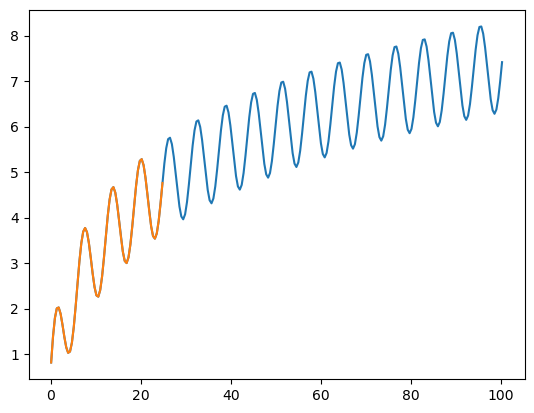

In [448]:
plt.plot(X_e[0][:-1],y_e_val[0])
plt.plot(X[0][:-1],y_val[0])
plt.show()

In [449]:
x_train.shape

In [450]:
y_train[0].shape

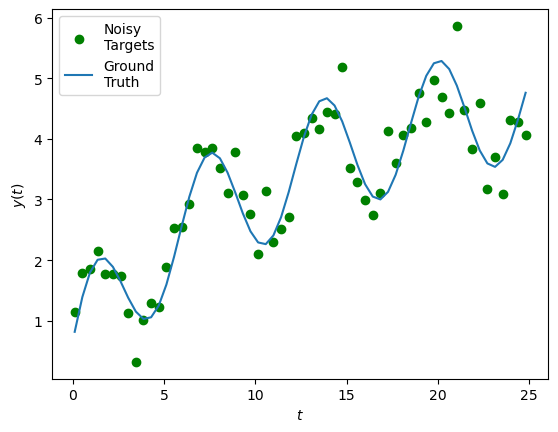

In [451]:
plt.scatter(X[0][:-1],y_train[0],c='green',label='Noisy\nTargets')
plt.plot(X[0][:-1],y_val[0],label='Ground\nTruth')
plt.ylabel('$y(t)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

### Test Model Shapes and Initial Predictions

In [452]:
model = RegressionNetwork()
summary(model,input_size=x_train[0:5].shape,device=device)

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Layer (type:depth-idx)                   Output Shape              Param #
RegressionNetwork                        [5, 60, 2]                --
├─Linear: 1-1                            [5, 60, 128]              128
├─MaskedSinePositionEmbedding: 1-2       [5, 60, 128]              --
├─Sequential: 1-3                        [5, 60, 128]              --
│    └─MaskedTransformerBlock: 2-1       [5, 60, 128]              --
│    │    └─LayerNorm: 3-1               [5, 60, 128]              256
│    │    └─MultiheadAttention: 3-2      [5, 60, 128]              66,048
│    │    └─LayerNorm: 3-3               [5, 60, 128]              256
│    │    └─Linear: 3-4                  [5, 60, 128]              16,512
│    │    └─GELU: 3-5                    [5, 60, 128]              --
│    └─MaskedTransformerBlock: 2-2       [5, 60, 128]              --
│    │    └─LayerNorm: 3-6               [5, 60, 128]              256
│    │    └─MultiheadAttention: 3-7      [5, 60, 128]              66,048

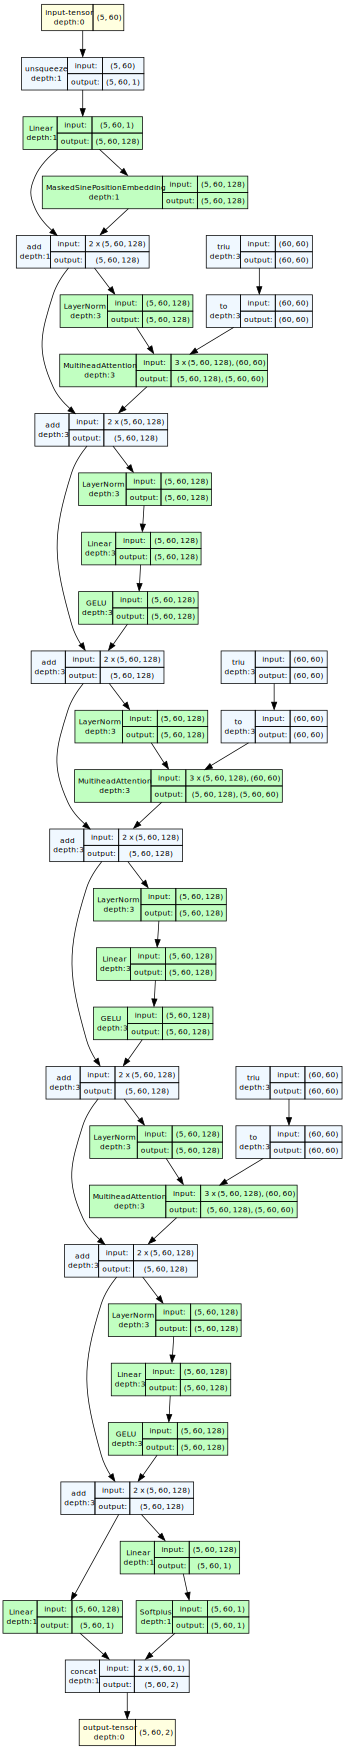

In [453]:
model_graph = draw_graph(model, input_size=x_train[0:5].shape, device=device,
                        hide_inner_tensors=True,hide_module_functions=True,
                        expand_nested=False, depth=3)
model_graph.visual_graph

In [454]:
x_val_masked = x_val.copy()
y_val_masked = y_val.copy()
x_train_masked = x_train.copy()
y_train_masked = y_train.copy()
x_val_masked[:,int(t*0.7):] = 0
y_val_masked[:,int(t*0.7):] = 0
x_train_masked[:,int(t*0.7):] = 0
y_train_masked[:,int(t*0.7):] = 0

In [455]:
x_1 = X[0:1][:,:-1]
x_1

array([[ 0.1       ,  0.51887902,  0.93775804,  1.35663706,  1.77551608,
         2.1943951 ,  2.61327412,  3.03215314,  3.45103216,  3.86991118,
         4.2887902 ,  4.70766923,  5.12654825,  5.54542727,  5.96430629,
         6.38318531,  6.80206433,  7.22094335,  7.63982237,  8.05870139,
         8.47758041,  8.89645943,  9.31533845,  9.73421747, 10.15309649,
        10.57197551, 10.99085453, 11.40973355, 11.82861257, 12.24749159,
        12.66637061, 13.08524963, 13.50412866, 13.92300768, 14.3418867 ,
        14.76076572, 15.17964474, 15.59852376, 16.01740278, 16.4362818 ,
        16.85516082, 17.27403984, 17.69291886, 18.11179788, 18.5306769 ,
        18.94955592, 19.36843494, 19.78731396, 20.20619298, 20.625072  ,
        21.04395102, 21.46283004, 21.88170906, 22.30058809, 22.71946711,
        23.13834613, 23.55722515, 23.97610417, 24.39498319, 24.81386221]])

In [456]:
y_1 = model.predict(torch.Tensor(x_val_masked).to(device))
# y_1 = model.predict(x_val)
y_mu = y_1[:,:,0].cpu().detach().numpy()
y_sigma = y_1[:,:,1].cpu().detach().numpy()
y_mu

array([[-0.7409147 , -1.4028131 , -1.5303942 , -1.7840532 , -1.8400043 ,
        -1.8120364 , -1.8192822 , -1.5347825 , -1.2925175 , -1.0345398 ,
        -1.0315164 , -1.0192432 , -1.2615069 , -1.452045  , -1.5502626 ,
        -1.6179054 , -1.5794119 , -1.6481935 , -1.7328426 , -1.8281057 ,
        -1.7407593 , -1.610829  , -1.4572161 , -1.3978351 , -1.3725624 ,
        -1.3874896 , -1.3492886 , -1.2743616 , -1.1409302 , -1.1791648 ,
        -1.3394278 , -1.5854864 , -1.7607291 , -1.8541228 , -1.8144034 ,
        -1.6638632 , -1.5929258 , -1.5732968 , -1.5751836 , -1.6474746 ,
        -1.6564018 , -1.6370867 , -0.94945997, -1.024177  , -1.0240281 ,
        -0.99966276, -0.9628373 , -0.9899403 , -0.98460805, -0.964185  ,
        -0.97672915, -0.9985589 , -0.9775623 , -0.99504185, -0.96751523,
        -0.9795433 , -0.99252534, -0.96019584, -0.9510559 , -0.93629825]],
      dtype=float32)

In [457]:
x_val_masked.shape

In [458]:
model.loss(model.predict(torch.Tensor(x_val_masked).to(device)),
           torch.Tensor(y_val_masked).to(device)).mean()

tensor(124.6061, device='cuda:0', grad_fn=<MeanBackward0>)

In [459]:
y_1.shape

torch.Size([1, 60, 2])

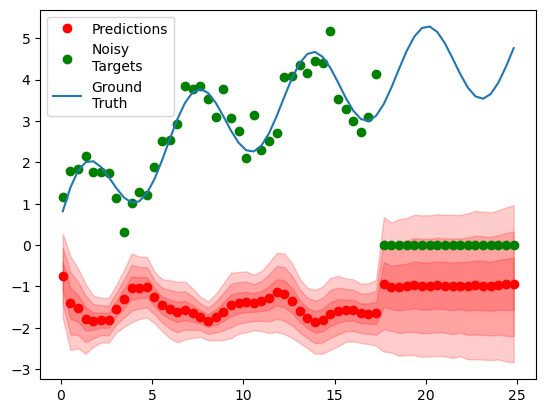

In [460]:
plt.plot(x_1[0],y_mu[0],'ro',label='Predictions')
plt.fill_between(x_1[0],
                 y_mu[0]-y_sigma[0],
                 y_mu[0]+y_sigma[0],
                 alpha=0.2,
                 color='red')
plt.fill_between(x_1[0],
                 y_mu[0]-2.0*y_sigma[0],
                 y_mu[0]+2.0*y_sigma[0],
                 alpha=0.2,
                 color='red')
plt.fill_between(x_1[0],
                 y_mu[0]-3.0*y_sigma[0],
                 y_mu[0]+3.0*y_sigma[0],
                 alpha=0.2,
                 color='red')
plt.plot(x_1[0],y_train_masked[0],'go',label='Noisy\nTargets')
plt.plot(x_1[0],y_val[0],label='Ground\nTruth')
plt.legend()
plt.show()

### Note - plot above shows network predictions *before* training (just random initial weights)

### Training Time

In [461]:
model = RegressionNetwork()

In [462]:
batch_size = 32
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_train),
                                                torch.Tensor(y_train))),
                                       shuffle=True, batch_size=batch_size,
                                       num_workers=8)
xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_val),
                                              torch.Tensor(y_val))),
                                     shuffle=False, batch_size=batch_size,
                                     num_workers=8)

/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [463]:
logger = pl.loggers.CSVLogger("lightning_logs",
                              name="Demo-Regression",
                              version="demo-0")

In [464]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=10,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [465]:
trainer.validate(model, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory lightning_logs/Demo-Regression/demo-0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    28.867778778076172     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 28.867778778076172}]

In [466]:
trainer.fit(model, xy_train, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                        | Params
-------------------------------------------------------------------
0 | embedding          | Linear                      | 128   
1 | position_embedding | MaskedSinePositionEmbedding | 0     
2 | transformer_blocks | Sequential                  | 249 K 
3 | mu                 | Linear                      | 129   
4 | sigma              | Linear                      | 129   
5 | sp                 | Softplus                    | 0     
-------------------------------------------------------------------
249 K     Trainable params
0         Non-trainable params
249 K     Total params
0.998     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [467]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_loss,epoch,step,train_loss
0,28.867779,0,0,NaN
1,0.073796,0,156,NaN
2,NaN,0,156,1.586583
3,-0.040090,1,313,NaN
4,NaN,1,313,0.505343
5,-0.017921,2,470,NaN
6,NaN,2,470,0.493540
7,0.039072,3,627,NaN
8,NaN,3,627,0.477717
9,-0.019986,4,784,NaN


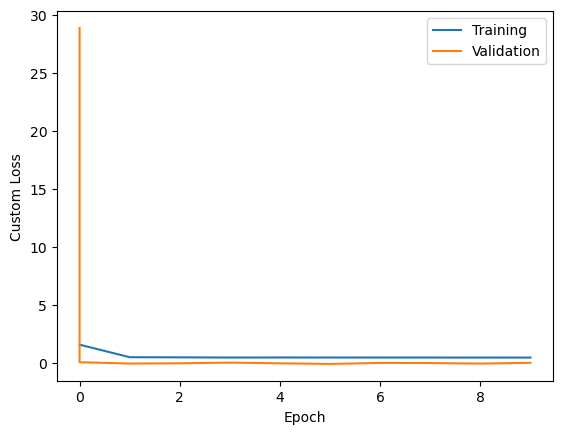

In [468]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")
plt.legend()
plt.ylabel("Custom Loss")
plt.xlabel("Epoch")
plt.show()

# Direct Validation of Results

In [469]:
x_1 = X[0:1][:,:-1]
x_1

array([[ 0.1       ,  0.51887902,  0.93775804,  1.35663706,  1.77551608,
         2.1943951 ,  2.61327412,  3.03215314,  3.45103216,  3.86991118,
         4.2887902 ,  4.70766923,  5.12654825,  5.54542727,  5.96430629,
         6.38318531,  6.80206433,  7.22094335,  7.63982237,  8.05870139,
         8.47758041,  8.89645943,  9.31533845,  9.73421747, 10.15309649,
        10.57197551, 10.99085453, 11.40973355, 11.82861257, 12.24749159,
        12.66637061, 13.08524963, 13.50412866, 13.92300768, 14.3418867 ,
        14.76076572, 15.17964474, 15.59852376, 16.01740278, 16.4362818 ,
        16.85516082, 17.27403984, 17.69291886, 18.11179788, 18.5306769 ,
        18.94955592, 19.36843494, 19.78731396, 20.20619298, 20.625072  ,
        21.04395102, 21.46283004, 21.88170906, 22.30058809, 22.71946711,
        23.13834613, 23.55722515, 23.97610417, 24.39498319, 24.81386221]])

In [470]:
x_val_masked.shape

In [471]:
x_val

array([[0.14691825, 0.81763744, 1.39064134, 1.79567727, 2.00628997,
        2.02649963, 1.88893775, 1.64972686, 1.37942515, 1.15137283,
        1.02944179, 1.05732833, 1.25126297, 1.59741564, 2.05445812,
        2.56085019, 3.04559659, 3.44062018, 3.69261544, 3.7723359 ,
        3.67971174, 3.4439145 , 3.11835896, 2.77150762, 2.47506863,
        2.29162849, 2.26385858, 2.40716225, 2.70703427, 3.12158959,
        3.58882434, 4.03735386, 4.3987713 , 4.61949003, 4.67002224,
        4.55008969, 4.28868285, 3.93905845, 3.56954029, 3.25171433,
        3.04805889, 3.00114924, 3.12630306, 3.40893846, 3.80710156,
        4.2587265 , 4.69237268, 5.0395826 , 5.24672361, 5.28426607,
        5.15189356, 4.87856167, 4.51749516, 4.13698851, 3.80860069,
        3.59478519, 3.53809435, 3.65382463, 3.92737453, 4.31677197]])

In [472]:
# y_1 = model.predict(x_val_masked)
model.to(device)
y_1 = model.predict(torch.Tensor(x_val).to(device)).cpu().detach().numpy()
y_mu = y_1[:,:,0]
y_sigma = y_1[:,:,1]
y_mu

array([[0.82206804, 1.3783236 , 1.7840668 , 1.9952042 , 2.001742  ,
        1.8708163 , 1.634733  , 1.3808191 , 1.143601  , 1.0157886 ,
        1.0451304 , 1.236843  , 1.590045  , 2.054815  , 2.5537195 ,
        3.0283995 , 3.4237652 , 3.6598072 , 3.7453775 , 3.6479201 ,
        3.4238095 , 3.0976918 , 2.7542512 , 2.4513848 , 2.2822094 ,
        2.258626  , 2.3880768 , 2.6915917 , 3.1009243 , 3.5778465 ,
        4.0205636 , 4.3848457 , 4.5864277 , 4.646692  , 4.5287814 ,
        4.2829633 , 3.9177365 , 3.5420983 , 3.2347314 , 3.0555367 ,
        2.9994347 , 3.1205919 , 3.3994915 , 3.8006504 , 4.2533245 ,
        4.6803412 , 5.030582  , 5.2380314 , 5.2617693 , 5.1229243 ,
        4.854002  , 4.50237   , 4.1344523 , 3.800427  , 3.5786393 ,
        3.511742  , 3.6386914 , 3.9163017 , 4.311685  , 4.727248  ]],
      dtype=float32)

In [473]:
y_1.shape

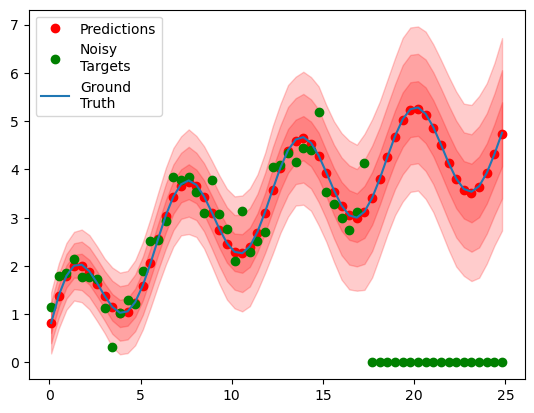

In [474]:
plt.plot(x_1[0],y_mu[0],'ro',label='Predictions')
plt.fill_between(x_1[0],
                 y_mu[0]-y_sigma[0],
                 y_mu[0]+y_sigma[0],
                 alpha=0.2,
                 color='red')
plt.fill_between(x_1[0],
                 y_mu[0]-2.0*y_sigma[0],
                 y_mu[0]+2.0*y_sigma[0],
                 alpha=0.2,
                 color='red')
plt.fill_between(x_1[0],
                 y_mu[0]-3.0*y_sigma[0],
                 y_mu[0]+3.0*y_sigma[0],
                 alpha=0.2,
                 color='red')
plt.plot(x_1[0],y_train_masked[0],'go',label='Noisy\nTargets')
plt.plot(x_1[0],y_val[0],label='Ground\nTruth')
plt.legend()
plt.show()

### Simulated and learned: $\sigma$

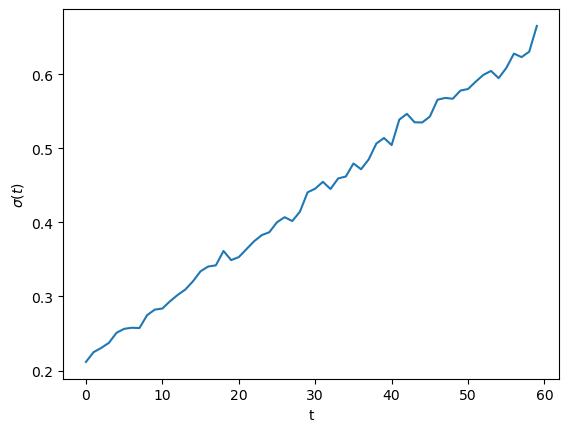

In [475]:
plt.plot(y_sigma[0])
plt.xlabel('t')
plt.ylabel('$\sigma(t)$')
plt.show()

### Extended extrapolation

In [476]:
x_1 = X_e[0:1][:,:-1]
x_1

array([[1.00000000e-01, 5.18879020e-01, 9.37758041e-01, 1.35663706e+00,
        1.77551608e+00, 2.19439510e+00, 2.61327412e+00, 3.03215314e+00,
        3.45103216e+00, 3.86991118e+00, 4.28879020e+00, 4.70766923e+00,
        5.12654825e+00, 5.54542727e+00, 5.96430629e+00, 6.38318531e+00,
        6.80206433e+00, 7.22094335e+00, 7.63982237e+00, 8.05870139e+00,
        8.47758041e+00, 8.89645943e+00, 9.31533845e+00, 9.73421747e+00,
        1.01530965e+01, 1.05719755e+01, 1.09908545e+01, 1.14097336e+01,
        1.18286126e+01, 1.22474916e+01, 1.26663706e+01, 1.30852496e+01,
        1.35041287e+01, 1.39230077e+01, 1.43418867e+01, 1.47607657e+01,
        1.51796447e+01, 1.55985238e+01, 1.60174028e+01, 1.64362818e+01,
        1.68551608e+01, 1.72740398e+01, 1.76929189e+01, 1.81117979e+01,
        1.85306769e+01, 1.89495559e+01, 1.93684349e+01, 1.97873140e+01,
        2.02061930e+01, 2.06250720e+01, 2.10439510e+01, 2.14628300e+01,
        2.18817091e+01, 2.23005881e+01, 2.27194671e+01, 2.313834

In [477]:
# y_1 = model.predict(x_val_masked)
y_1 = model.predict(torch.Tensor(x_e_val).to(device)).cpu().detach().numpy()
y_mu = y_1[:,:,0]
y_sigma = y_1[:,:,1]
y_mu

array([[0.8220681, 1.3783236, 1.7722194, 1.9899466, 2.0097106, 1.868983 ,
        1.6299374, 1.360717 , 1.1439145, 1.024865 , 1.0398321, 1.2473505,
        1.5923105, 2.0349293, 2.5468287, 3.0216212, 3.411769 , 3.6566644,
        3.7512193, 3.6516175, 3.4221287, 3.0991876, 2.7466784, 2.4606783,
        2.2580256, 2.2192523, 2.3728395, 2.6828117, 3.0977356, 3.5636203,
        4.008274 , 4.3730416, 4.586651 , 4.6452656, 4.544318 , 4.271325 ,
        3.9136689, 3.5481596, 3.2305264, 3.0419424, 3.0025337, 3.1088033,
        3.3859687, 3.7852821, 4.2472944, 4.675432 , 5.0323405, 5.2368507,
        5.2463875, 5.1343226, 4.869732 , 4.5150814, 4.1225295, 3.805341 ,
        3.572132 , 3.5133538, 3.6369197, 3.9158545, 4.3164377, 4.721134 ,
        5.0820417, 5.352381 , 5.5136604, 5.5626163, 5.5392165, 5.425539 ,
        5.238894 , 4.994602 , 4.6938114, 4.3662577, 4.0961432, 3.9757133,
        4.058109 , 4.2964067, 4.6736073, 5.1196976, 5.5333495, 5.869583 ,
        6.089536 , 6.0406322, 5.846246

In [478]:
y_1.shape

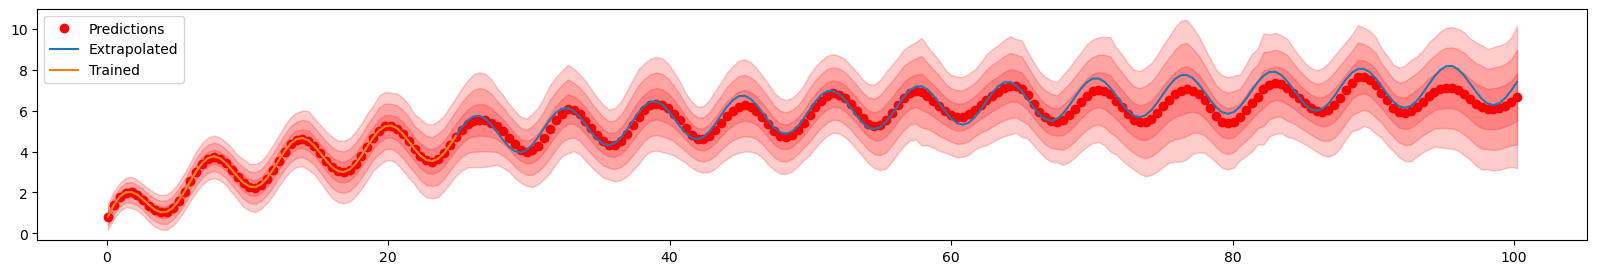

In [479]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(x_1[0],y_mu[0],'ro',label='Predictions')
plt.fill_between(x_1[0],
                 y_mu[0]-y_sigma[0],
                 y_mu[0]+y_sigma[0],
                 alpha=0.2,
                 color='red')
plt.fill_between(x_1[0],
                 y_mu[0]-2.0*y_sigma[0],
                 y_mu[0]+2.0*y_sigma[0],
                 alpha=0.2,
                 color='red')
plt.fill_between(x_1[0],
                 y_mu[0]-3.0*y_sigma[0],
                 y_mu[0]+3.0*y_sigma[0],
                 alpha=0.2,
                 color='red')
#plt.plot(x_1[0],y_train_masked[0],'go',label='Noisy\nTargets')
plt.plot(x_1[0],y_e_val[0],label='Extrapolated')
plt.plot(X[0,:-1],y_val[0],label='Trained')
plt.legend()
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]